<a href="https://colab.research.google.com/github/ysgrProgramming/solve_ivp_tutorial/blob/main/solve_ivp_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pythonで常微分方程式を解き物理アニメーションを作る

scipyのintegrate.solve_ivpで常微分方程式を解き、matplotlib.animationやIPython.display.HTMLで物理アニメーションを作成する。

## scipy.integrate.solve_ivpについて

> scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
>
> [scipy.integrate.solve_ivp — SciPy v1.8.1 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)より引用

第一引数には導関数を指定し、第二引数には$t$の間隔を指定し、第三引数には初期値のリストを指定する。

### 一階常微分方程式の求解

試しに、次の微分方程式について解いてみる。

\begin{eqnarray}
\frac{dx}{dt} = -x, x(0)=1
\end{eqnarray}

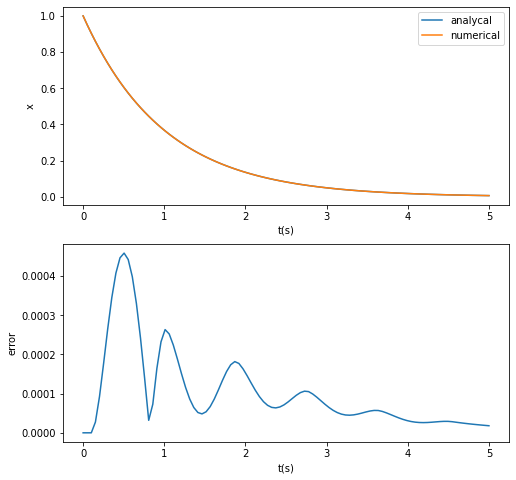

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def func(t, x):
    return -x

t_max = 5
t_span = [0, t_max]
t = np.linspace(0, t_max, 100)
init = [1]
sol = solve_ivp(func, t_span, init, t_eval=t)

def compare_plot(t, analycal, numerical):
    fig, axs = plt.subplots(2, figsize=(8, 8))
    axs[0].set_xlabel("t(s)")
    axs[0].set_ylabel("x")
    axs[0].plot(t, analycal, label="analycal")
    axs[0].plot(t, numerical, label="numerical")
    axs[0].legend()

    axs[1].set_xlabel("t(s)")
    axs[1].set_ylabel("error")
    axs[1].plot(t, abs(analycal-numerical))

    plt.show()

compare_plot(t, sol.y[0], np.exp(-t))

厳密解は$x(t)=\exp(-t)$であり、求解結果と一致している。誤差も少ない。

### 二階常微分方程式の求解

次に、二階常微分方程式であるニュートンの運動方程式について解いてみる。

\begin{eqnarray}
m \frac{d^2 x}{dt^2} = F, x(0)=0, \left.\frac{dx}{dt}\right|_{x=0}=-2
\end{eqnarray}

二階常微分方程式の時は、２つの一階常微分方程式に分ける。

\begin{eqnarray}
\frac{dx}{dt}=v, \frac{dv}{dt}=\frac{F}{m}
\end{eqnarray}

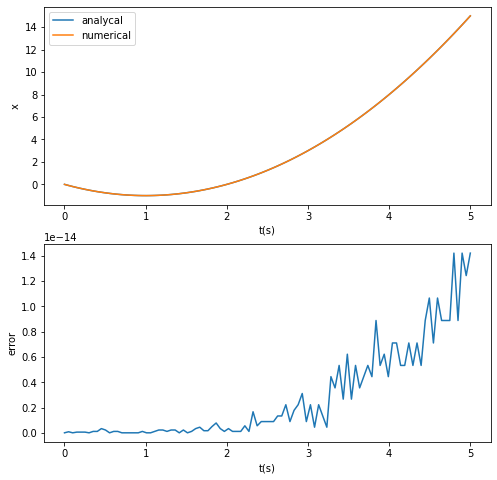

In [ ]:
F, m = 1, 0.5
init = [0, -2]

def func(t, states):
    x, v = states
    d = np.zeros_like(states)
    d[0] = v
    d[1] = F/m
    return d

sol = solve_ivp(func, [0, t_max], init, t_eval=t)
ny = F/(2*m)*t**2-2*t
compare_plot(t, sol.y[0], ny)

厳密解は$x(t)=\frac{F}{2m}t^2-2t$であり、求解結果と一致している。誤差も少ない。

## アニメーションの作成方法

matplotlibのplot関数の返り値のリストを作成し、animation.ArtistAnimationの引数として代入することでアニメーションを作成することができる。

作成したアニメーションは、save関数によってgifアニメーションとして出力したり、IPython.display.HTMLによって簡易的な再生機能を持ったHTMLに変換することができる。

以下は、右に流れるsin波のアニメーションを作成するデモである。

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

def func(x, t):
    return np.sin(2*np.pi*(x-t))

x = np.linspace(0, 3, 100)
dt = 0.05
ims = []
fig = plt.figure()
for i in range(20):
    t = dt*i
    im = plt.plot(x, func(x, t), "k-")
    ims.append(im)
plt.close()

anim = animation.ArtistAnimation(fig, ims, interval=1000*dt)

#gifアニメーションに変換し出力
anim.save("wave.gif", writer="pillow")

#HTMLに変換しアニメーションを可視化
HTML(anim.to_jshtml())

## 斜方投射のアニメーションの作成

solve_ivpとmatplotlib.animationを使って斜方投射のアニメーションを作成してみる。

解くべき微分方程式は、$x, y, v_x, v_y$の微分方程式として

\begin{eqnarray}
\frac{dx}{dt} &=& v_x, \quad \frac{d v_x}{dt} = 0\\
\frac{dy}{dt} &=& v_y, \quad \frac{d v_y}{dt} = -g
\end{eqnarray}

の4つである。

In [54]:
g = 9.8
v0, theta = 20, 45
v0x, v0y = v0 * np.cos(theta*np.pi/180), v0 * np.sin(theta*np.pi/180)
dt, t_max = 0.05, 5
t_length = int(t_max//dt+1)
init = [0, v0x, 0, v0y]

t = np.linspace(0, t_max, t_length)

def func1(t, states):
    x, vx, y, vy = states
    d = np.zeros_like(states)
    d[0] = vx
    d[1] = 0
    d[2] = vy
    d[3] = -g
    return d

sol1 = solve_ivp(func1, [0, t_max], init, t_eval=t)
sol1.y = sol1.y[:,sol1.y[2] > -1]
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.grid()

ims = []
for i in range(len(sol1.y[0])):
    im = ax.plot(sol1.y[0][:i+1], sol1.y[2][:i+1], "b-")
    im += ax.plot(sol1.y[0][i], sol1.y[2][i], "bo")
    ims.append(im)
plt.close()

anim = animation.ArtistAnimation(fig, ims, interval=1000*dt)

HTML(anim.to_jshtml())

## 空気抵抗を加味した斜方投射アニメーションの作成

空気抵抗があるときの微分方程式は、

\begin{eqnarray}
\frac{dx}{dt} = v_x, \quad \frac{d{v_x}}{dt} = -\frac{\kappa}{m}\sqrt{v_x^2+v_y^2}v_x\\
\frac{dy}{dt} = v_y, \quad \frac{d{v_y}}{dt} = -\frac{\kappa}{m}\sqrt{v_x^2+v_y^2}v_y-g
\end{eqnarray}

In [55]:
m = 0.1
kappa = 1e-3
v0 = 20
theta = 45
v0x, v0y = v0 * np.cos(theta*np.pi/180), v0 * np.sin(theta*np.pi/180)
dt, t_max = 0.05, 5
t_length = int(t_max//dt+1)
init = [0, v0x, 0, v0y]

t = np.linspace(0, t_max, t_length)

def func2(t, states):
    x, vx, y, vy = states
    v = np.sqrt(vx**2 + vy**2)
    d = np.zeros_like(states)
    d[0] = vx
    d[1] = -kappa/m*v*vx
    d[2] = vy
    d[3] = -kappa/m*v*vy-g
    return d

sol2 = solve_ivp(func2, [0, t_max], init, t_eval=t)
sol2.y = sol2.y[:,sol2.y[2] > -1]
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.grid()

ims = []
for i in range(len(sol.y[0])):
    im = ax.plot(sol2.y[0][:i+1], sol2.y[2][:i+1], "b-")
    im += ax.plot(sol2.y[0][i], sol2.y[2][i], "bo")
    ims.append(im)
plt.close()

anim = animation.ArtistAnimation(fig, ims, interval=1000*dt)

HTML(anim.to_jshtml())

双方を比べてみた結果がこちら。

In [66]:
fig, axs = plt.subplots(2, figsize=(10, 10))

ims = []
axs[0].plot([], [], "ro", label="no resistance")
axs[0].plot([], [], "bo", label="air resistance")
axs[1].plot([], [], "r-", label="no resistance")
axs[1].plot([], [], "b-", label="air resistance")
axs[0].legend()
axs[1].legend()

axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[1].set_xlabel("t(s)")
axs[1].set_ylabel("v")

for i in range(min(len(sol1.y[0]), len(sol2.y[0]))):
    im = axs[0].plot(sol1.y[0][:i+1], sol1.y[2][:i+1], "r-")
    im += axs[0].plot(sol1.y[0][i], sol1.y[2][i], "ro")
    im += axs[0].plot(sol2.y[0][:i+1], sol2.y[2][:i+1], "b-")
    im += axs[0].plot(sol2.y[0][i], sol2.y[2][i], "bo")

    im += axs[1].plot(np.arange(i+1)*dt, np.sqrt(sol1.y[1][:i+1]**2 + sol1.y[3][:i+1]**2), "r-")
    im += axs[1].plot(np.arange(i+1)*dt, np.sqrt(sol2.y[1][:i+1]**2 + sol2.y[3][:i+1]**2), "b-")
    ims.append(im)
plt.close()

anim = animation.ArtistAnimation(fig, ims, interval=1000*dt)

HTML(anim.to_jshtml())